Training data
Number of rows: 42000
Number of columns: 785


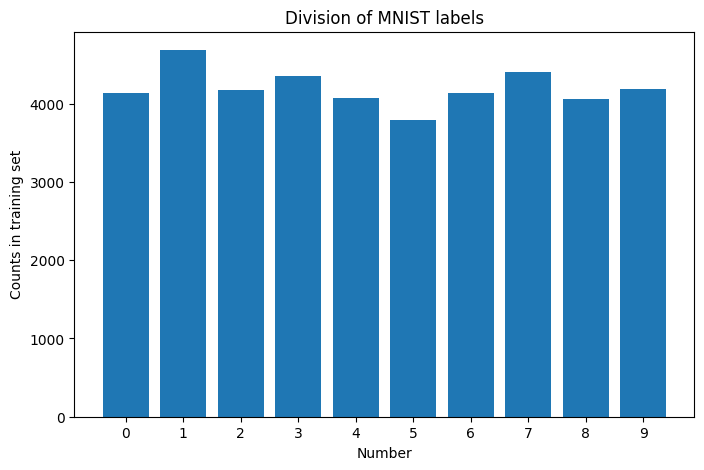

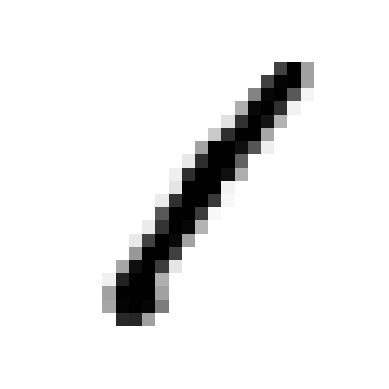

Plotting digit no 0, Label: 1
Epoch 1/30
263/263 - 20s - 77ms/step - accuracy: 0.8631 - loss: 0.4405 - val_accuracy: 0.2073 - val_loss: 3.4367
Epoch 2/30
263/263 - 17s - 64ms/step - accuracy: 0.9540 - loss: 0.1516 - val_accuracy: 0.9380 - val_loss: 0.2044
Epoch 3/30
263/263 - 17s - 63ms/step - accuracy: 0.9643 - loss: 0.1184 - val_accuracy: 0.9773 - val_loss: 0.0710
Epoch 4/30
263/263 - 17s - 63ms/step - accuracy: 0.9706 - loss: 0.0965 - val_accuracy: 0.9705 - val_loss: 0.0946
Epoch 5/30
263/263 - 17s - 63ms/step - accuracy: 0.9727 - loss: 0.0879 - val_accuracy: 0.9835 - val_loss: 0.0537
Epoch 6/30
263/263 - 17s - 63ms/step - accuracy: 0.9768 - loss: 0.0775 - val_accuracy: 0.9840 - val_loss: 0.0483
Epoch 7/30
263/263 - 17s - 63ms/step - accuracy: 0.9780 - loss: 0.0739 - val_accuracy: 0.9865 - val_loss: 0.0443
Epoch 8/30
263/263 - 17s - 63ms/step - accuracy: 0.9800 - loss: 0.0658 - val_accuracy: 0.9900 - val_loss: 0.0339
Epoch 9/30
263/263 - 16s - 63ms/step - accuracy: 0.9812 - loss: 0.

In [ ]:
# Kaggle MNIST competition
# evalutation metric: accuracy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# data loading
train_original = pd.read_csv('train.csv')
test_original = pd.read_csv('test.csv')

# a little data exploration
train_exploration = train_original.copy()

print("Training data")
print("Number of rows:", train_exploration.shape[0])
print("Number of columns:", train_exploration.shape[1])

counts = train_exploration['label'].value_counts().sort_index()

# Plot division of numbers in training set
plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values)
plt.xlabel("Number")
plt.ylabel("Counts in training set")
plt.title("Division of MNIST labels")
plt.xticks(counts.index) 
plt.show()

# plot a digit
def plot_digit(image):
    """Helper function to plot a digit"""
    plt.imshow(image.reshape(28, 28), cmap='binary')
    plt.axis('off')
    plt.show()

digit_no = 0
plot_digit(train_exploration.iloc[digit_no, 1:].values)
print(f"Plotting digit no {digit_no}, Label: {train_exploration.iloc[digit_no, 0]}")

# Convolutional Neural Network (CNN)

y = train_original['label'].values
X = train_original.drop(columns=['label']).values.astype("float32") / 255.0
X = X.reshape(-1, 28, 28, 1) # Reshape for CNN input

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1)
])

model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    data_augmentation,

    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

# Evaluate model 
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Predict on test data and prepare submission
X_test = test_original.values.astype("float32") / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)
test_predictions = model.predict(X_test)
test_pred_labels = np.argmax(test_predictions, axis=1)  

submission = pd.DataFrame({
    "ImageId": np.arange(1, len(test_pred_labels) + 1),
    "Label": test_pred_labels
})
submission.to_csv("submission.csv", index=False)

